<a href="https://colab.research.google.com/github/TonmoyTalukder/Img2Cap/blob/main/Img2Cap_Image_captioning_using_LM_T5_or_VitGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate caption from image detecting objects
**Author:** [Tonmoy Talukder](https://tonmoytalukder.github.io/)

## Install and Imports

In [1]:
%%capture
!pip3 install transformers
!pip3 install sentencepiece
!pip3 install timm

import torch
import torchvision
import numpy as np
import pandas as pd
import random
from PIL import Image
import re
import requests
import spacy

from transformers import (
    ViltProcessor,
    ViltForMaskedLM,
    DetrFeatureExtractor,
    DetrForObjectDetection,
    AutoModelWithLMHead,
    AutoTokenizer,
    PegasusForConditionalGeneration,
    PegasusTokenizer,
    CLIPProcessor,
    CLIPModel,
    VisionEncoderDecoderModel,
    ViTFeatureExtractor,
)

## Utils: Neccesary Functions

In [2]:
class Image2CaptionUtils:
    def __init__(self):
        self.objList = ["dobj", "obj", "iobj"]

    def predict_step(self, image_paths, feature_extractor, model, tokenizer):
        images = [Image.open(requests.get(image_path, stream=True).raw).convert("RGB") for image_path in image_paths]

        pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
        pixel_values = pixel_values.to(device)

        output_ids = model.generate(pixel_values, max_length=60, num_beams=10)

        preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        preds = [pred.strip() for pred in preds]
        return preds[0]

    def get_object_phrase(self, doc):
        for token in doc:
            if token.dep_ in self.objList:
                subtree = list(token.subtree)
                start = subtree[0].i
                end = subtree[-1].i + 1
                return doc[start:end]

    def get_masked_sentences(self, objects):
        masked_sentences = []

        for i1, id1 in enumerate(objects):
            for j, id2 in enumerate(objects):
                if id1 != id2:
                    k = f"{id1} [MASK] {id2}"
                    masked_sentences.append(k)
        return masked_sentences

    def remove_subject_starting_with_object(self, sentences):
        nlp1 = spacy.load('en_core_web_sm')

        objList = ["dobj", "obj", "iobj"]
        cleaned_sentences = []

        for sentence in sentences:
            doc = nlp1(sentence)
            object_phrase = None  # Assuming get_object_phrase is a function you have defined
            if object_phrase and str(object_phrase) == str(sentence.split()[0]):
                print(sentence)
            else:
                cleaned_sentences.append(sentence)

        return cleaned_sentences

    def trained_t5_model(self, words, t5tokenizer, t5model, max_length=32):
        words = " ".join(words)
        input_text = words
        features = t5tokenizer([input_text], return_tensors='pt')
        output = t5model.generate(
            input_ids=features['input_ids'],
            attention_mask=features['attention_mask'],
            max_length=max_length
        )
        return t5tokenizer.decode(output[0], skip_special_tokens=True)

## Image2Caption

In [3]:
class Image2Caption:
    def __init__(self, image, utils, feature_extractor0, model0, processor1, model1, model2name, processor2, model4,
                 t5tokenizer, t5model, model_gpt, feature_extractor_gpt, tokenizer_gpt):
        self.image = image
        self.utils = utils
        self.device0 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device4 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device5 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device6 = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize models and processors
        self.feature_extractor0 = feature_extractor0
        self.model0 = model0.to(self.device0)

        self.processor1 = processor1
        self.model1 = model1.to(self.device1)

        self.model2name = model2name
        self.tokenizer = PegasusTokenizer.from_pretrained(self.model2name)
        self.model3 = PegasusForConditionalGeneration.from_pretrained(self.model2name).to(self.device5)

        self.model4 = model4.to(self.device4)
        self.processor2 = processor2

        self.t5tokenizer = t5tokenizer
        self.t5model = t5model
        self.model_gpt = model_gpt.to(self.device6)
        self.feature_extractor_gpt = feature_extractor_gpt
        self.tokenizer_gpt = tokenizer_gpt

    def object_detection(self, image):
        inputs = self.feature_extractor0(images=image, return_tensors="pt").to(self.device0)
        outputs = self.model0(**inputs)

        target_sizes = torch.tensor([image.size[::-1]])
        results = self.feature_extractor0.post_process(outputs, target_sizes=target_sizes)[0]

        objects = []
        for score, label in zip(results["scores"], results["labels"]):
            if score > 0.95:
                objects.append(str(self.model0.config.id2label[label.item()]))

        return np.unique(objects)

    def mask_detected_words(self, sentence_list1, image):
        sentence_list2 = []

        for i2 in enumerate(sentence_list1):
            text = i2[1]

            encoding = self.processor1(image, text, return_tensors="pt").to(self.device1)
            outputs = self.model1(**encoding)

            tl = len(re.findall("\[MASK\]", text))
            inferred_token = [text]

            with torch.no_grad():
                for i3 in range(tl):
                    encoded = self.processor1.tokenizer(inferred_token)
                    input_ids = torch.tensor(encoded.input_ids)
                    encoded = encoded["input_ids"][0][1:-1]
                    mlm_logits = outputs.logits[0]
                    mlm_logits = mlm_logits[1: input_ids.shape[1] - 1, :]
                    mlm_values, mlm_ids = mlm_logits.softmax(dim=-1).max(dim=-1)
                    mlm_values[torch.tensor(encoded) != 103] = 0
                    select = mlm_values.argmax().item()
                    encoded[select] = mlm_ids[select].item()
                    inferred_token = [self.processor1.decode(encoded)]

            selected_token = ""
            encoded = self.processor1.tokenizer(inferred_token)
            output = self.processor1.decode(encoded.input_ids[0], skip_special_tokens=True)
            sentence_list2.append(output)

        return sentence_list2

    def get_response(self, input_text, model, tokenizer, num_return_sequences, num_beams):
        batch = tokenizer([input_text], truncation=True, padding='longest', max_length=60, return_tensors="pt").to(self.device5)
        translated = model.generate(**batch, num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
        tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
        return tgt_text

    def process_image(self):
        # image = Image.open(requests.get(self.image_path, stream=True).raw).convert('RGB')
        detected_objects = self.object_detection(self.image)

        if len(detected_objects) >= 2 and 'N/A' not in detected_objects:
            sentence_list1 = self.utils.get_masked_sentences(detected_objects)
            masked_sentences = self.mask_detected_words(sentence_list1, image)
            cleaned_sentences = self.utils.remove_subject_starting_with_object(masked_sentences)

            sentence_list2 = cleaned_sentences
            cleaned_keywords = cleaned_sentences

            # ------- T5 Model ------- #
            gen_cap_t5 = self.utils.trained_t5_model(cleaned_keywords, t5tokenizer, t5model,)

            # ------- Pharaphrasing ------- #
            paraphrased_sentences = self.get_response(gen_cap_t5, self.model3, self.tokenizer, num_return_sequences=10, num_beams=10)

            # ------- Clip Model ------- #
            inputs = self.processor2(text=paraphrased_sentences, images=image, return_tensors="pt", padding=True).to(self.device4)
            outputs = self.model4(**inputs)
            logits_per_image = outputs.logits_per_image

            max_val, index = logits_per_image[0].max(dim=0)
            print(paraphrased_sentences[index])

        elif len(detected_objects) == 1 and 'N/A' in detected_objects:
            # Continue with GPT processing
            gen_cap_gpt = self.utils.predict_step([self.image_path], self.feature_extractor_gpt, self.model_gpt, self.tokenizer_gpt)
            print(gen_cap_gpt)

## Models, Tokenizers and Processors

In [ ]:
# Initialize utilities and models
utils = Image2CaptionUtils()

# Initialize models outside of the class
feature_extractor0 = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model0 = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

processor1 = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-coco")
model1 = ViltForMaskedLM.from_pretrained("dandelin/vilt-b32-finetuned-coco")

model2name = 'tuner007/pegasus_paraphrase'
tokenizer = PegasusTokenizer.from_pretrained(model2name)
model4 = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor2 = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

t5tokenizer = AutoTokenizer.from_pretrained("t5-base")
t5model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-common_gen")

model_gpt = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor_gpt = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer_gpt = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

## Caption Generate from Image

In [5]:
# Usage
def img2Cap(url):
    image_processor = Image2Caption(
        url, utils, feature_extractor0, model0, processor1, model1, model2name, processor2, model4, t5tokenizer, t5model,
        model_gpt, feature_extractor_gpt, tokenizer_gpt
    )

    return image_processor.process_image()

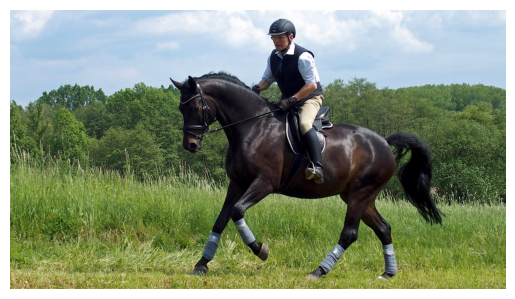

A person is wearing clothes on a horse.


In [ ]:
import matplotlib.pyplot as plt

img_path = 'https://www.wehorse.com/en/blog/wp-content/uploads/2022/01/Adults-learn-to-ride-scaled.jpg'
image = Image.open(requests.get(img_path, stream=True).raw).convert('RGB')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

img2Cap(image)